In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
def clamp(x, x_min, x_max):
    '''This ensures  x_min <= x <= x_max'''
    return min(x_max, max(x_min, x))

clamp(-1, 0, 10)

0

In [3]:
class CarParam:
    max_steering_angle = 0.5435 # radians
    max_steering_rate = 0.3294 # radians / second
    max_speed = 30.0 # m/s
    characteristic_velocity = 20.0 # m/s - drives side slip
    steer_damping = 1.0 / 0.3 # seconds
    accel_damping = 1.0 / 0.3 # seconds
    max_braking_accel = -6.0 # m/s^2
    max_forward_accel = 1.8 # m/s^2
    length = 2.885 # meters    
    
    def __init__(self):
        pass
        

carParams = CarParam()

In [4]:
class SimulatedCarState:
    x = np.array([0, #0 - x position
                  0, #1 - x speed
                  0, #2 - y position
                  0, #3 - y speed 
                  0, #4 - forward speed
                  0, #5 - forward acceleration
                  0, #6 - forward jerk
                  0, #7 - heading angle
                  0, #8 - heading rate
                  0, #9 - steering angle
                  0]) #10 - steering rate
    
    xi = 0
    xdi = 1
    yi = 2
    ydi = 3
    fsi = 4
    fai = 5
    fji = 6
    hai = 7
    hri = 8
    sai = 9
    sri = 10
    
    def __init__(self, x, carParams):
        self.x = x
        self.carParams = carParams
    
    def input_steering(self, u_steer):
        '''Take in a desired steering angle and get the resulting steering rate'''
        # ensure the desired steering angle is possible 
        u_steer = clamp(u_steer, -self.carParams.max_steering_angle, self.carParams.max_steering_angle)
        # set the rate - will push to actual steering angle in update function
        self.x[self.sri] = self.carParams.steer_damping * (u_steer - self.x[self.sai])
        # ensure the resulting steering rate is possible
        self.x[self.sri] = clamp(self.x[self.sri], -carParams.max_steering_rate, carParams.max_steering_rate)
        
    def input_accel(self, u_accel):
        '''Take in a desired acceleration and get the resulting acceleration rate (jerk)'''
        # ensure the desired acceleration is possible 
        u_accel = clamp(u_accel, self.carParams.max_braking_accel , self.carParams.max_forward_accel)
        # set the rate - will push to actual steering angle in update function
        self.x[self.fji] = carParams.steer_damping * (u_accel - self.x[self.fai])
        
    def tic(self, dt):
        #
        Gss = 1 / (1.0 + (self.x[self.fsi]/self.carParams.characteristic_velocity)**2)
        A = np.array([[1.0,  dt,   0,  0,                                                    0,   0,         0,   0,  0,   0,   0], # x_k+1 = x_k + xdot*dt
                      [  0,   0,   0,  0,                        dt*math.cos(self.x[self.hai]),   0,         0,   0,  0,   0,   0], # xdot = forward speed * cos(heading)
                      [  0,   0, 1.0, dt,                                                    0,   0,         0,   0,  0,   0,   0], # y_k+1 = y_k + ydot * dt 
                      [  0,   0,   0,  0,                        dt*math.sin(self.x[self.hai]),   0,         0,   0,  0,   0,   0], # ydot = forward speed * sin(heading)
                      [  0,   0,   0,  0,                                                  1.0,  dt, 0.5*dt**2,   0,  0,   0,   0], # forward speed_k+1 = forward speed_k + forward acceleration * dt + 0.5*forward jerk_k * dt^2 
                      [  0,   0,   0,  0,                                                    0, 1.0,        dt,   0,  0,   0,   0], # forward acceleration_k+1 = forward_acceleration_k + forward_jerk * dt
                      [  0,   0,   0,  0,                                                    0,   0,       1.0,   0,  0,   0,   0], # forward jerk_k+1 = forward_jerk_k
                      [  0,   0,   0,  0,                                                    0,   0,         0, 1.0, dt,   0,   0], # heading angle_k+1 = heading_angle_k + heading_angle rate_k * dt
                      [  0,   0,   0,  0, math.tan(self.x[self.sai])*Gss/self.carParams.length,   0,         0,   0,  0,   0,   0], # heading angle rate_k+1= forward_speed_k * 1/L*tan(steering_angle)*Gss
                      [  0,   0,   0,  0,                                                    0,   0,         0,   0,  0, 1.0,  dt], # steering angle_k+1 = steering angle_k + steering angle_rate_k * dt
                      [  0,   0,   0,  0,                                                    0,   0,         0,   0,  0,   0, 1.0]]) # steering angle rate_k+1 = steering angle rate_k
        
        self.x = A @ self.x

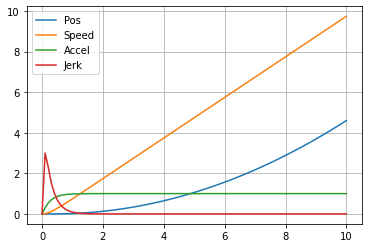

In [5]:
# check the car's acceleration
dt = 0.1
x = np.array([0, #0 - x position
                0, #1 - x speed
                0, #2 - y position
                0, #3 - y speed 
                0, #4 - forward speed
                0, #5 - forward acceleration
                0, #6 - forward jerk
                0, #7 - heading angle
                0, #8 - heading rate
                0, #9 - steering angle
                0]) #10 - steering rate

car = SimulatedCarState(x, carParams)

times = []

poss = []
speeds = []
accels = []
jerks = []

t = 0.0
while t < 10.0:
    times.append(t)
    poss.append(car.x[car.xi])
    speeds.append(car.x[car.fsi])
    accels.append(car.x[car.fai])
    jerks.append(car.x[car.fji])  
    car.input_accel(1.0)
    car.tic(dt)
    t += dt

plt.plot(times, poss, label='Pos')
plt.plot(times, speeds, label='Speed')
plt.plot(times, accels, label='Accel')
plt.plot(times, jerks, label='Jerk')
plt.legend()
plt.grid()
plt.show()


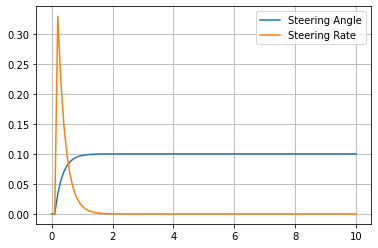

In [6]:
# check the car's steering
dt = 0.1
x = np.array([0, #0 - x position
                0, #1 - x speed
                0, #2 - y position
                0, #3 - y speed 
                0, #4 - forward speed
                0, #5 - forward acceleration
                0, #6 - forward jerk
                0, #7 - heading angle
                0, #8 - heading rate
                0, #9 - steering angle
                0]) #10 - steering rate

car = SimulatedCarState(x, carParams)

times = []

sas = []
srs = []

t = 0.0
while t < 10.0:
    times.append(t)
    sas.append(car.x[car.sai])
    srs.append(car.x[car.sri])
    car.input_steering(0.1)
    car.tic(dt)
    t += dt

plt.plot(times, sas, label='Steering Angle')
plt.plot(times, srs, label='Steering Rate')
plt.legend()
plt.grid()
plt.show()

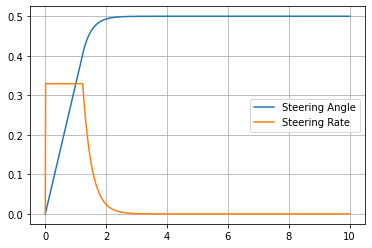

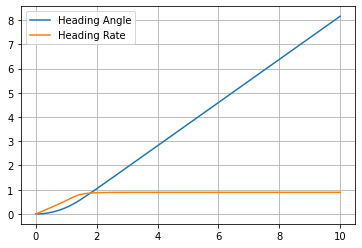

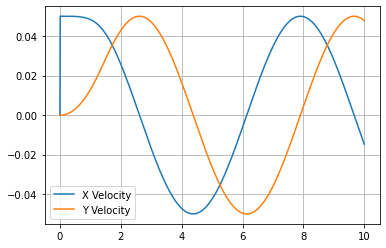

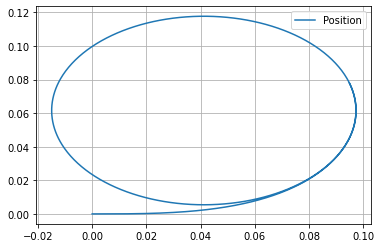

In [7]:
# check the car's steering effects the body
dt = 0.01
x = np.array([0, #0 - x position
                0, #1 - x speed
                0, #2 - y position
                0, #3 - y speed 
              5.0, #4 - forward speed
                0, #5 - forward acceleration
                0, #6 - forward jerk
                0, #7 - heading angle
                0, #8 - heading rate
                0, #9 - steering angle
                0]) #10 - steering rate

car = SimulatedCarState(x, carParams)

times = []

sas = []
srs = []
has = []
hrs = []
xs = []
xds = []
ys = []
yds = []

t = 0.0
while t < 10.0:
    times.append(t)
    sas.append(car.x[car.sai])
    srs.append(car.x[car.sri])
    has.append(car.x[car.hai])
    hrs.append(car.x[car.hri])
    xs.append(car.x[car.xi])
    xds.append(car.x[car.xdi])
    ys.append(car.x[car.yi])
    yds.append(car.x[car.ydi])
    
    
    car.input_steering(0.5)
    car.tic(dt)
    t += dt

plt.plot(times, sas, label='Steering Angle')
plt.plot(times, srs, label='Steering Rate')
plt.legend()
plt.grid()
plt.show()

plt.plot(times, has, label='Heading Angle')
plt.plot(times, hrs, label='Heading Rate')
plt.legend()
plt.grid()
plt.show()

plt.plot(times, xds, label='X Velocity')
plt.plot(times, yds, label='Y Velocity')
plt.legend()
plt.grid()
plt.show()

plt.plot(xs, ys, label='Position')
plt.legend()
plt.grid()
plt.show()
